In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from datasets import load_metric

In [2]:
# Function to load IMDB data
def load_imdb_data(data_file):
    df = pd.read_csv(data_file)
    # df = df.sample(frac=0.01, random_state=42)
    texts = df['review'].tolist()
    labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]
    return texts, labels

# Dataset class for sentiment analysis
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Function to train the model 
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        val_loss = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}, Avg Loss: {epoch_loss / len(train_loader)}, Val Loss: {val_loss}")

# Function to evaluate the model
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)


data_file = "IMDB Dataset.csv"
texts, labels = load_imdb_data(data_file)

# Split the dataset into train, validation, and test sets (80% train, 10% validation, 10% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, test_size=0.333, random_state=42)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, output_attentions=True)

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare datasets and dataloaders
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len=256)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_len=256)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len=256)

print(f"Train dataset size: {len(train_dataset)}", f"Val dataset size: {len(val_dataset)}", f"Test dataset size: {len(test_dataset)}", sep='\n')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train the model
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=1)


c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `

Train dataset size: 35000
Val dataset size: 10005
Test dataset size: 4995


Epoch 1/1: 100%|██████████| 2188/2188 [07:31<00:00,  4.84it/s, loss=0.0654]


Epoch 1, Avg Loss: 0.2680867085832646, Val Loss: 0.2236905974907259


In [3]:
#save the model
torch.save(model.state_dict(), 'model.pth')

In [4]:
print(len(test_loader))

313


In [5]:
# Function to evaluate the model on test set with tqdm progress bar
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Example usage
test_model(model, test_loader, device)


Testing: 100%|██████████| 313/313 [00:17<00:00, 18.30it/s]

Test Accuracy: 0.9145
Precision: 0.9223
Recall: 0.9058
F1 Score: 0.9140


(0.9145145145145145,
 0.9223261488409923,
 0.9057507987220448,
 0.9139633286318759)

### DistilBert has 6 layer of attentions and Each layer has 12 heads

# Evaluation

In [6]:
def predict_sentiment(model, tokenizer, sentence, device):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=64, padding='max_length').to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    
    print(f"Predicted sentiment for \"{sentence}\": {sentiment}")
    return sentiment


In [7]:
# Test the model on a sample sentence or file 
test_sentence = "i LOVE THIS MOVIE So much"

# Predict sentiment
predict_sentiment(model, tokenizer, test_sentence, device)

Predicted sentiment for "i LOVE THIS MOVIE So much": Positive


'Positive'

## Visualize ALL layerS' attention with ALL heads

In [8]:
def visualize_all_layer_attention_all_heads(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text and get tokens
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  # Get token list
    
    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Access attention weights
    attention_weights = outputs.attentions  # List of attention matrices from each layer
    print(f"Number of layers: {len(attention_weights)}")
    print(f"Number of heads: {len(attention_weights[0][0].detach().cpu().numpy())}")
    print(f"Number of tokens: {len(tokens)}")
    
    # Plotting the heatmap for the first attention head (attention_matrix[0])
    fig, ax = plt.subplots(6,12, figsize=(40, 20))
    for i in range(len(attention_weights)):
        attention_matrix = attention_weights[i][0].detach().cpu().numpy()
        for j in range(len(attention_matrix)):
            sns.heatmap(attention_matrix[j], cmap="viridis", xticklabels=tokens, yticklabels=tokens, ax=ax[i, j], vmin=0, vmax=1)
            
            ax[i, j].set_title(f"Layer {i+1}, Head {j+1}")
            # title size
            ax[i, j].title.set_size(8)
            ax[i, j].set_xlabel("Token Attention")
            ax[i, j].set_ylabel("Tokens")

            # Set x-axis and y-axis token labels size 
            ax[i, j].xaxis.set_tick_params(labelsize=5)
            ax[i, j].yaxis.set_tick_params(labelsize=5)

            # ROMVE X AND Y TICKS
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    # plt.tight_layout()
    plt.xticks(rotation=90)  # Rotate x-axis token labels for readability
    plt.tight_layout()
    plt.show()

    fig.savefig('attention_all_layers_all_heads.png')


Number of layers: 6
Number of heads: 12
Number of tokens: 8


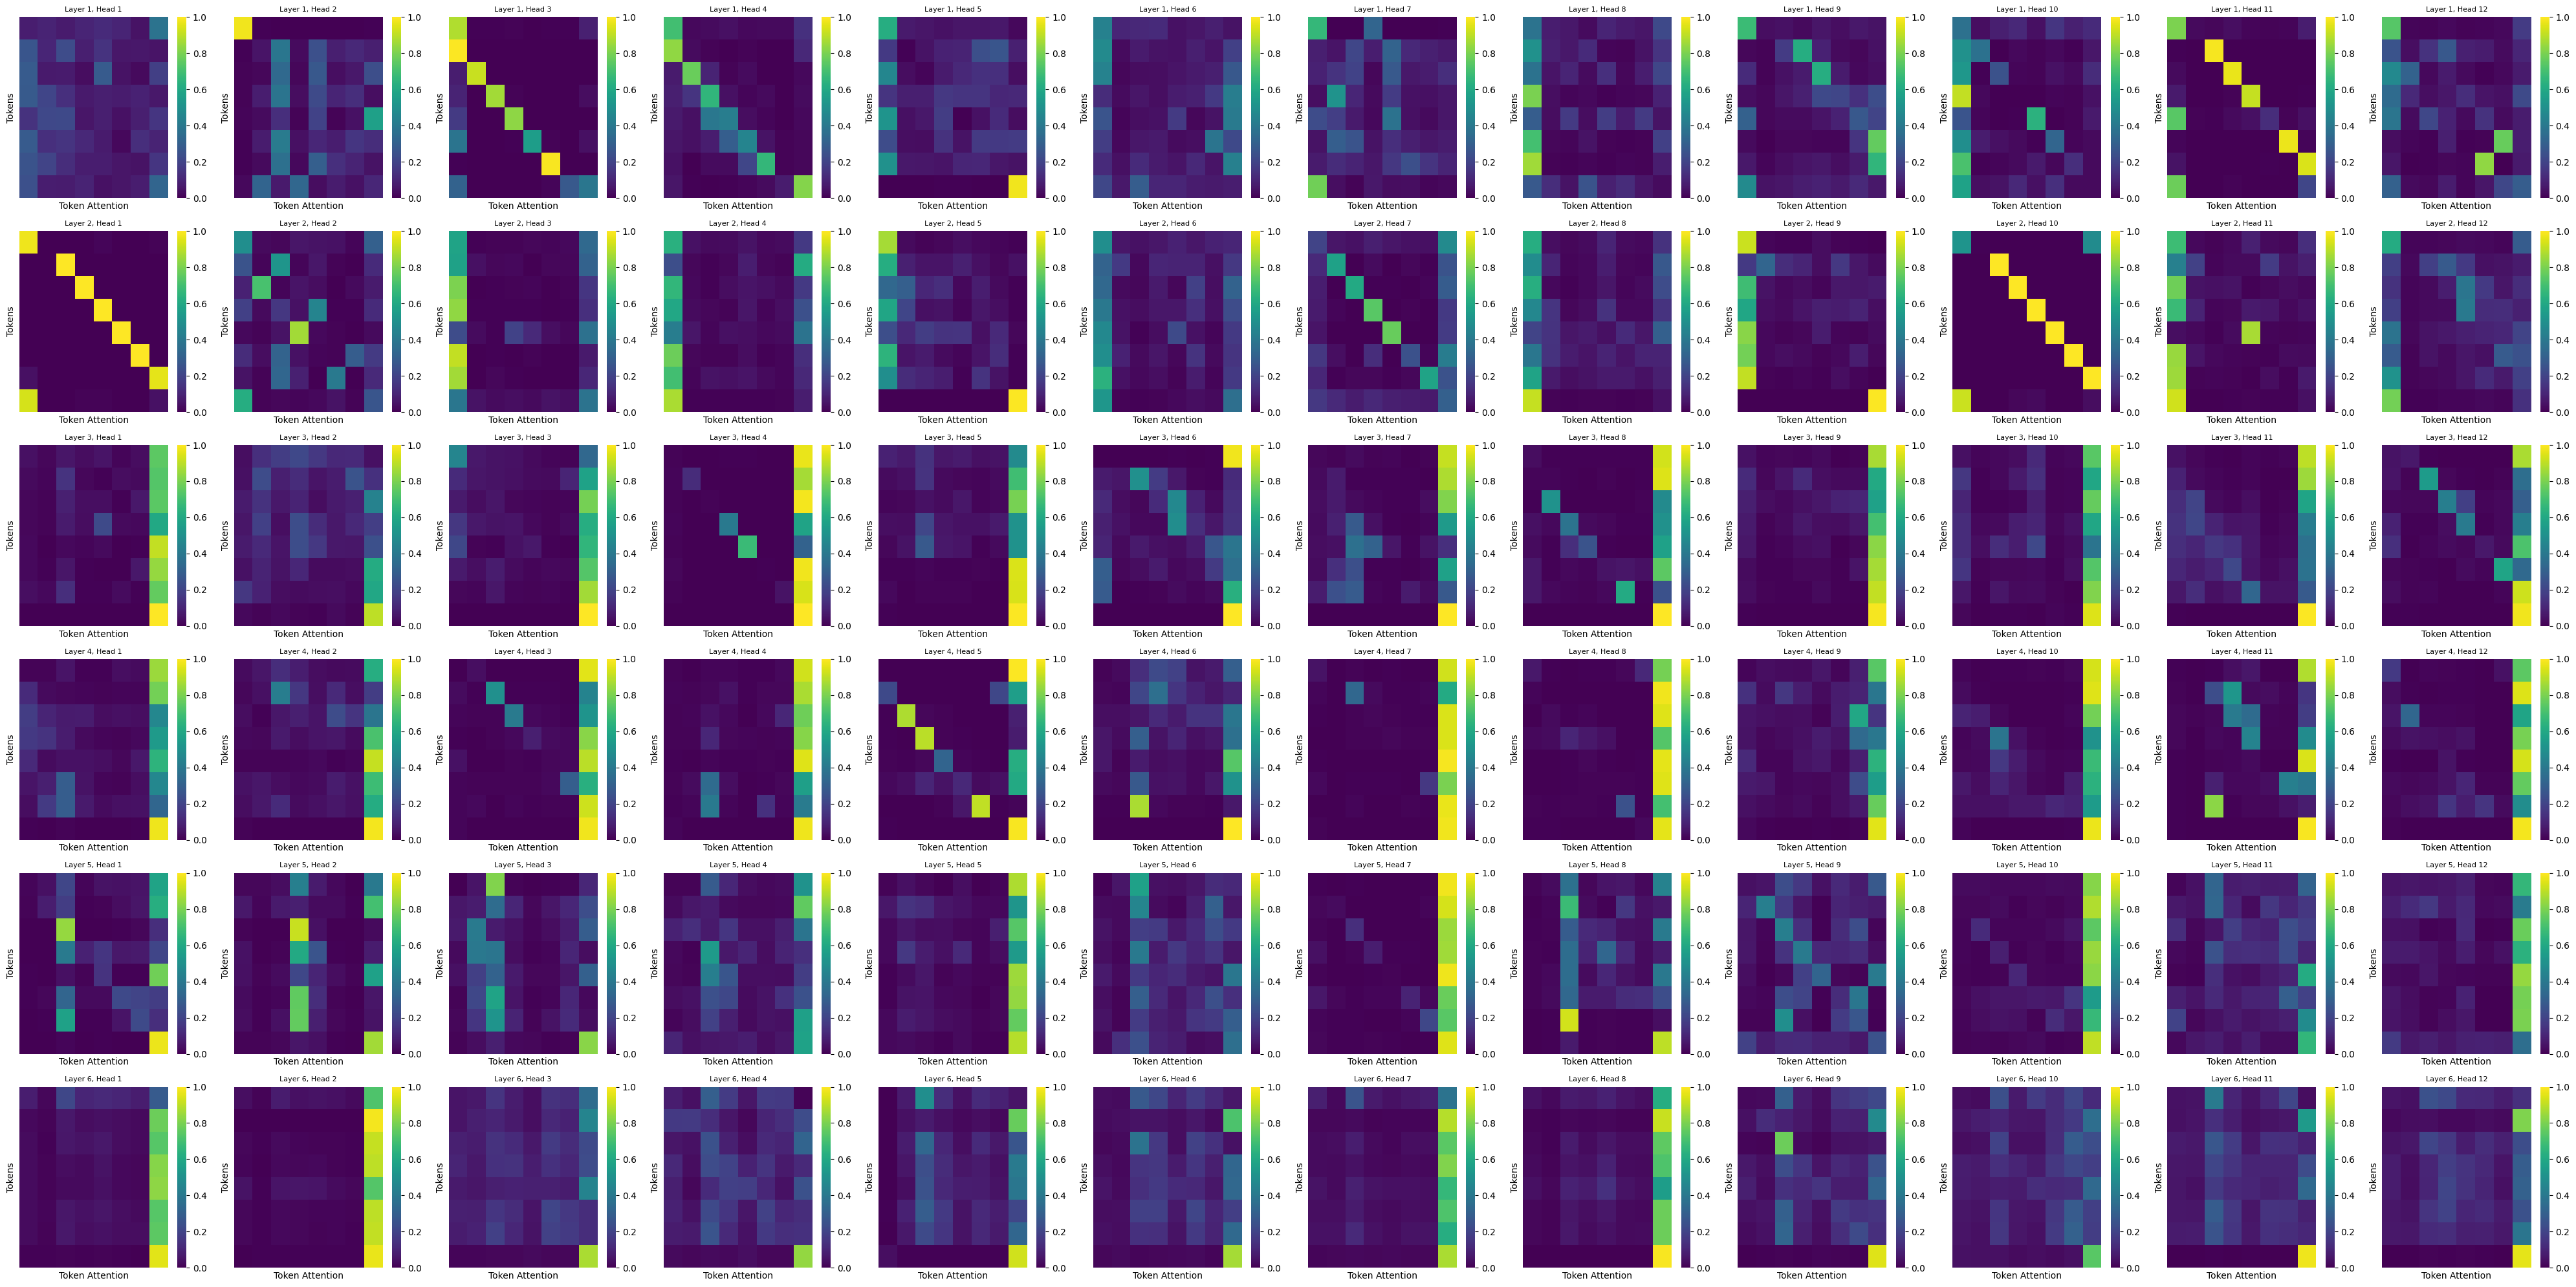

In [9]:
# Visualize attention for the all layers and all heads
visualize_all_layer_attention_all_heads(model, tokenizer, test_sentence, device)


## Visualize DIFFERENT layers' attention with ALL heads

The shape of the last layer attention: torch.Size([12, 8, 8])
The shape of the attention matrix: (12, 8, 8)


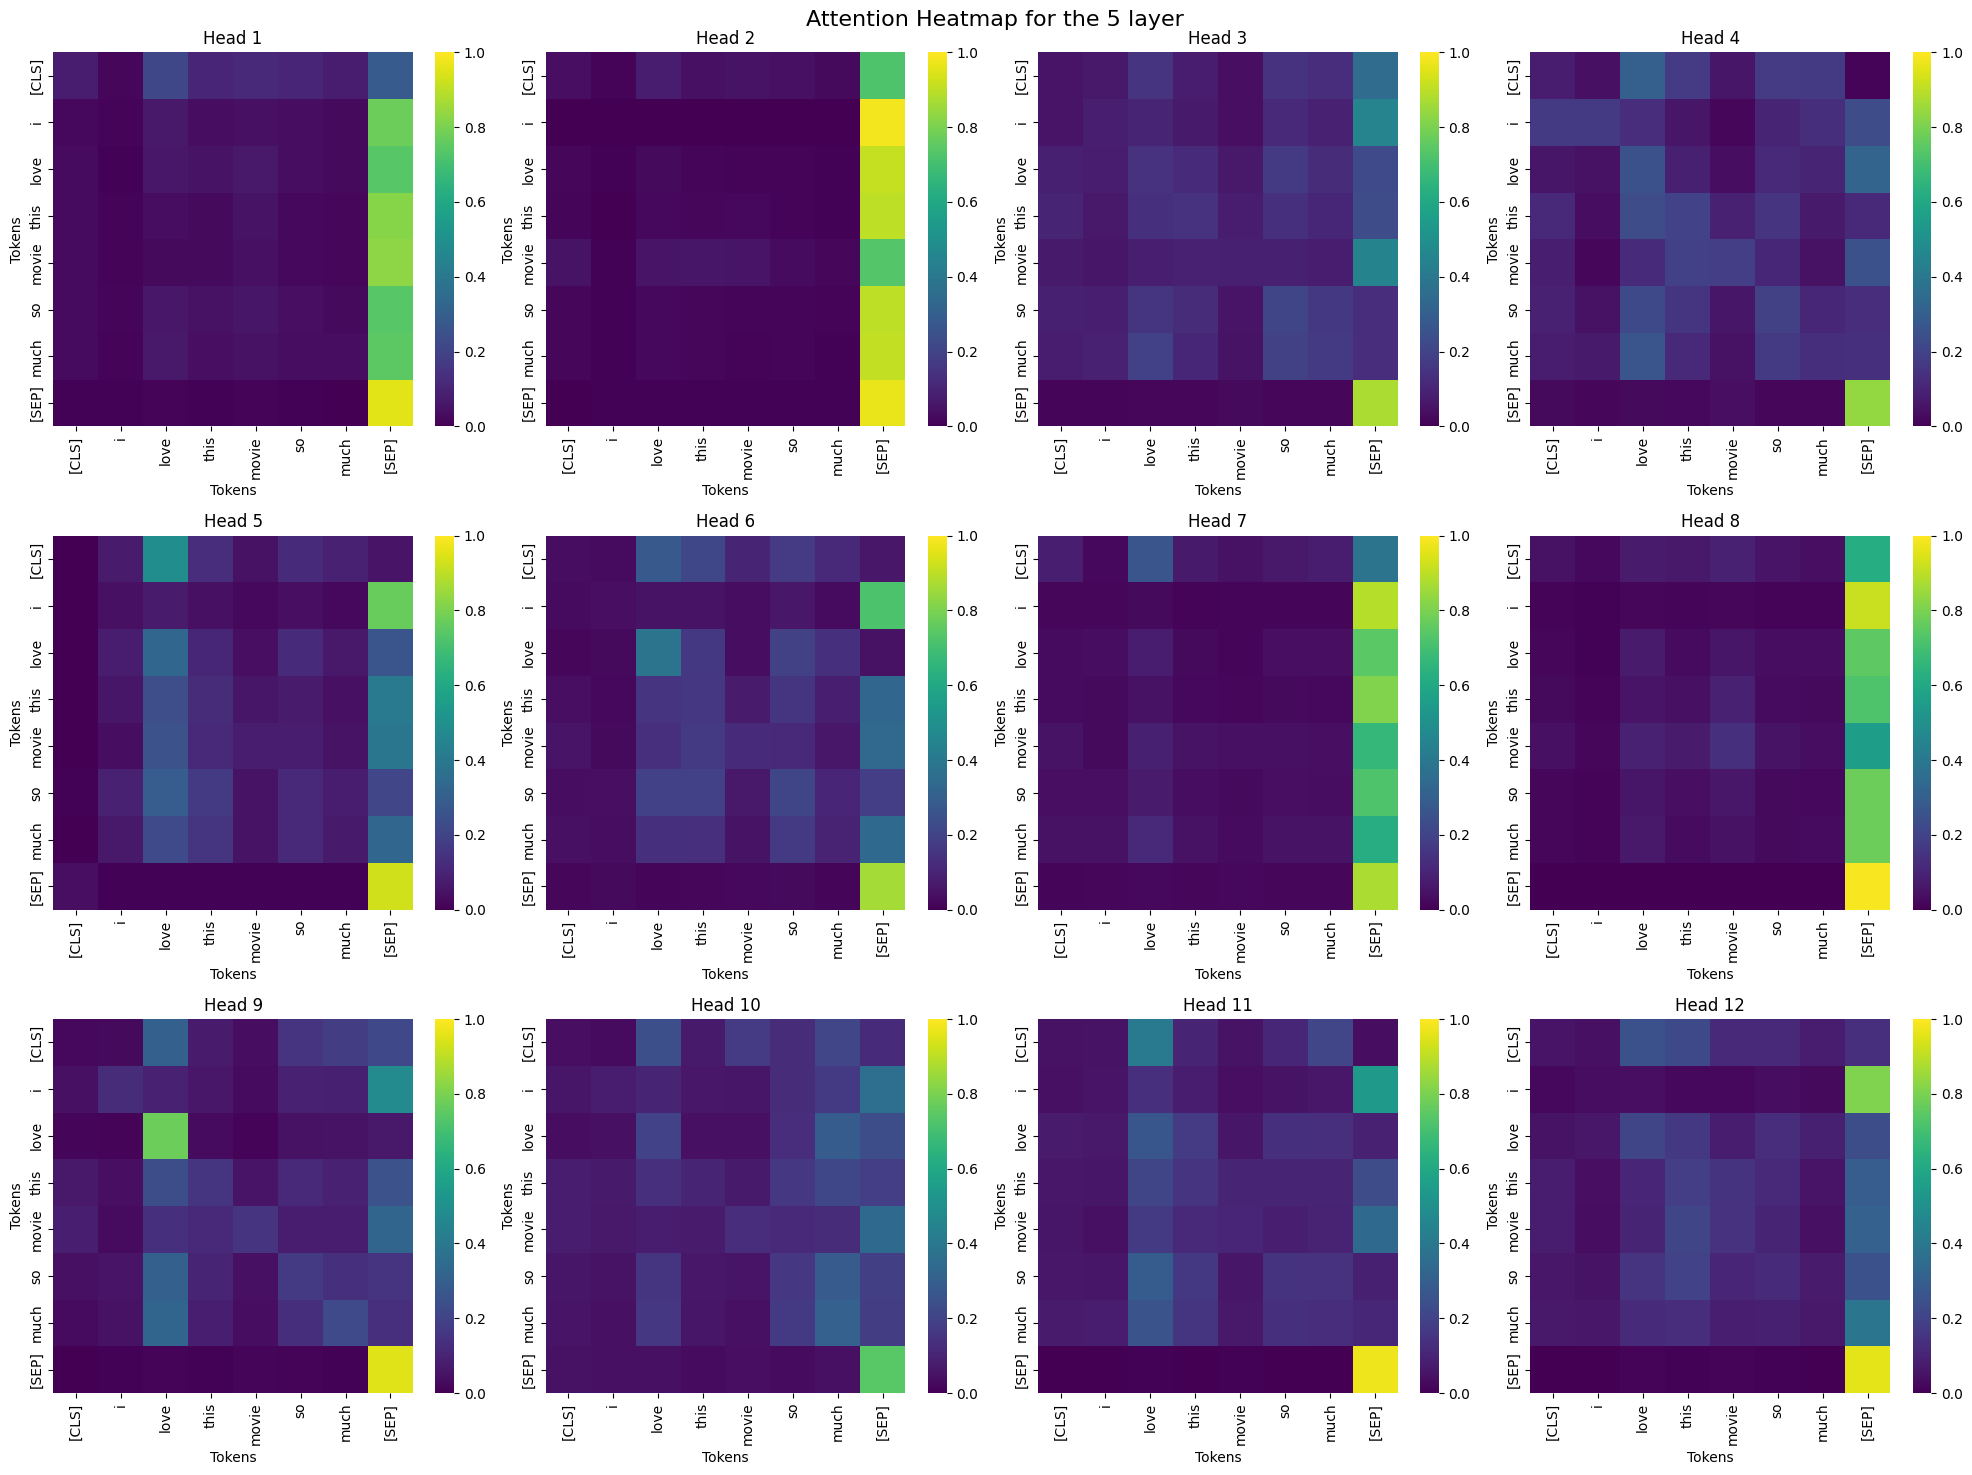

In [10]:
def visualize_lastlayer_attention_all_heads(model, tokenizer, text, device, selected_layer=5):
    model.eval()  # Set model to evaluation mode

    # Tokenize the input text and get tokens
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, max_length=64).to(device)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())  # Get token list
    
    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Access last layer attention weights
    last_layer_attention = outputs.attentions[selected_layer]  
    print(f"The shape of the last layer attention: {last_layer_attention[0].shape}")

    # Get the attention matrix for each head
    attention_matrix = last_layer_attention[0].detach().cpu().numpy()  # Shape: (num_heads, seq_len, seq_len)
    print(f"The shape of the attention matrix: {attention_matrix.shape}")

    # Plotting the heatmap for each attention head
    num_heads = attention_matrix.shape[0]
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    seq_len = attention_matrix.shape[1]  # Length of the sequence
    for i in range(num_heads):
        ax = axes[i//4, i%4]
        sns.heatmap(attention_matrix[i], cmap="viridis", xticklabels=tokens, yticklabels=tokens, ax=ax, vmin=0, vmax=1)

        ax.set_title(f"Head {i+1}")
        ax.set_xlabel("Tokens")
        ax.set_ylabel("Tokens")
        
        # # Set ticks and labels
        # ax.x_ticks(range(seq_len), tokens, rotation=90)
    
    # Title and labels for the entire plot
    plt.suptitle(f"Attention Heatmap for the {selected_layer} layer", fontsize=16)
    plt.tight_layout()
    plt.xticks(rotation=90)  # Rotate x-axis token labels for readability
    plt.tight_layout()
    plt.show()


# Visualize attention heatmap for the same sentence for all heads, 
# ### Selected_layer is the layer number to visualize
visualize_lastlayer_attention_all_heads(model, tokenizer, test_sentence, device)


### Print Model

In [11]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 